In [1]:
## Modifies scMetabolism to take arbitrary GMT file
## Uses a mouse GMT file to extend the method to mouse data.

In [2]:
suppressWarnings(suppressPackageStartupMessages({
    library(scMetabolism)
    library(ggplot2)
    library(rsvd)
    library(Seurat)
    library(ggplot2)
    library(gridExtra)
    library(grid)
    library(viridis)
    library(reshape2)
}))

In [3]:
## Modify scmetabolism function to accept any arbitrary GMT file as input.
sc.metabolism.Seurat <- function(obj, method="VISION", imputation=F, ncores=2, metabolism.type="KEGG", meta.file.path=NULL) {
  countexp<-obj@assays$RNA@counts
  countexp<-data.frame(as.matrix(countexp))
  # signatures_KEGG_metab <- "./data/KEGG_metabolism_nc.gmt"
  # signatures_REACTOME_metab <- "./data/REACTOME_metabolism.gmt"
  # Output of these are just file paths.
  if (metabolism.type=="file") {
      signatures_file_path <- meta.file.path
  } else {
      signatures_KEGG_metab <- system.file("data", "KEGG_metabolism_nc.gmt", package="scMetabolism")
      signatures_REACTOME_metab <- system.file("data", "REACTOME_metabolism.gmt", package="scMetabolism")
  }
  if (metabolism.type=="KEGG")  {gmtFile <- signatures_KEGG_metab; cat("Your choice is: KEGG\n")}
  if (metabolism.type=="REACTOME")  {gmtFile <- signatures_REACTOME_metab; cat("Your choice is: REACTOME\n")}
  if (metabolism.type=="file") {gmtFile <- signatures_file_path; cat("Using custom GMT file.\n")}

  ## Imputation
  if (imputation==F) {
    countexp2<-countexp
  }
  if (imputation==T) {
    cat("Starting imputation...\n")
    # Citation: George C. Linderman, Jun Zhao, Yuval Kluger. 
    # Zero-preserving imputation of scRNA-seq data using low-rank approximation. 
    # bioRxiv. doi: https://doi.org/10.1101/397588
    # Github: https://github.com/KlugerLab/ALRA
    result.completed <- alra(as.matrix(countexp))
    countexp2 <- result.completed[[3]]
    row.names(countexp2) <- row.names(countexp)
  }

  cat("Quantifying metabolism activity...\n")

  ## VISION
  if (method=="VISION") {
    library(VISION)
    n.umi <- colSums(countexp2)
    scaled_counts <- t(t(countexp2) / n.umi) * median(n.umi)
    vis <- Vision(scaled_counts, signatures=gmtFile)
    options(mc.cores=ncores)
    vis <- analyze(vis)
    signature_exp <- data.frame(t(vis@SigScores))
  }

  ## AUCell
  if (method=="AUCell") {
    library(AUCell)
    library(GSEABase)
    cells_rankings <- AUCell_buildRankings(as.matrix(countexp2), nCores=ncores, plotStats=F) # rank
    geneSets <- getGmt(gmtFile) # signature read
    cells_AUC <- AUCell_calcAUC(geneSets, cells_rankings) # calc
    signature_exp <- data.frame(getAUC(cells_AUC))
  }

  ## ssGSEA
  if (method=="ssGSEA") {
    library(GSVA)
    library(GSEABase)
    geneSets <- getGmt(gmtFile) # signature read
    gsva_es <- gsva(as.matrix(countexp2), geneSets, method=c("ssgsea"), kcdf=c("Poisson"), parallel.sz=ncores) #
    signature_exp<-data.frame(gsva_es)
  }

  ## GSVA
  if (method=="GSVA") {
    library(GSVA)
    library(GSEABase)
    geneSets <- getGmt(gmtFile) #signature read
    gsva_es <- gsva(as.matrix(countexp2), geneSets, method=c("gsva"), kcdf=c("Poisson"), parallel.sz=ncores) #
    signature_exp<-data.frame(gsva_es)
  }

  obj@assays$METABOLISM$score<-signature_exp
  obj
}

In [4]:
## Function for pulling p-value and r-squared from scMeta results.
get_model_pr <- function(model) {
    r.squared <- summary(model)$r.squared
    f <- summary(model)$fstatistic
    p <- pf(f[1],f[2],f[3],lower.tail=F)
    return(c(r.squared, p))
}

In [5]:
## Fig size setting function
fig_size <- function(height, width) {
    options(repr.plot.height=height, repr.plot.width=width)
}

In [6]:
## Set paths -- point prj.dir at host dir for information. Directory needs following structure:
# prj.dir
#    examples/
#    sourcefiles/
#        pt_bm_integrated_umap.rds
#        mouse_hallmark.gmt
#    intermediates/
#    results/
#    figs/
prj.dir <- "/scratch/gpfs/KANG/sereno/foryujiao/scmeta"
exa.dir <- file.path(prj.dir, "example")
src.dir <- file.path(prj.dir, "sourcefiles")
int.dir <- file.path(prj.dir, "intermediates")
res.dir <- file.path(prj.dir, "results")
fig.dir <- file.path(prj.dir, "figs")

In [7]:
## This file should be in the {prj.dir}/sourcefiles path.
pt.bm.path <- file.path(src.dir, "pt_bm_integrated_umap.rds")
pt.bm.obj <- readRDS(pt.bm.path)

In [8]:
## Filter to just tumor cells
DefaultAssay(pt.bm.obj) <- "RNA"
tumor.mask <- grepl("Tumor", pt.bm.obj$cell_type)
for.scm.obj <- pt.bm.obj[, tumor.mask]

In [9]:
## Run scMeta with custom GMT file
custom.gmt.path <- file.path(src.dir, "mouse_hallmark.gmt")
for.scm.obj <- suppressWarnings(suppressPackageStartupMessages({
               sc.metabolism.Seurat(obj=for.scm.obj, method="AUCell", 
                                    imputation=F, ncores=2, metabolism.type="file", 
                                    meta.file.path=custom.gmt.path)
               }))

Using custom GMT file.
Quantifying metabolism activity...


Genes in the gene sets NOT available in the dataset: 
	Glycolysis: 	7 (4% of 200)
	Oxidative Phosphorylation: 	13 (7% of 195)
	Hypoxia: 	12 (6% of 199)



In [10]:
# Format scMeta results for postprocessing
meta.stat.df <- for.scm.obj@assays$METABOLISM$score
pt.bm.ident <- for.scm.obj@meta.data$orig.ident
pt.mask <- (pt.bm.ident=="pt")
bm.mask <- (pt.bm.ident=="bm")

In [11]:
# Wilcoxon Rank-Sum Test / Mann-Whitney U Test
path.pvals <- apply(meta.stat.df, 1, function(meta.row.df) {
    meta.row <- unlist(meta.row.df)
    p.val <- wilcox.test(meta.row~pt.bm.ident)$'p.value'
    return(p.val)
})
# Bonferroni correction
path.pval.corr <- path.pvals * length(path.pvals)
path.pval.corr[path.pval.corr > 1] <- 1

In [12]:
## Pvalues of rank-sum test between Primary Tumor (PT) and Bone Metastasis (BM) for each pathway from scMeta
path.pval.corr

Glycolysis Oxidative Phosphorylation                   Hypoxia 
            1.420636e-185              7.914922e-51              3.135984e-42

In [13]:
# Format scMeta scores for plotting and analysis of Hypoxia vs Glycolysis and Oxphos
glyc.scores <- unlist(for.scm.obj@assays$METABOLISM$score["Glycolysis", ])
oxph.scores <- unlist(for.scm.obj@assays$METABOLISM$score["Oxidative Phosphorylation", ])
hypo.scores <- unlist(for.scm.obj@assays$METABOLISM$score["Hypoxia", ])
umap.embed <- Embeddings(for.scm.obj, reduction="umap")
umap.1 <- umap.embed[, 1]
umap.2 <- umap.embed[, 2]
scm.feature.df <- data.frame(umap1=umap.1, umap2=umap.2, 
                             glyc=glyc.scores, oxph=oxph.scores, hypo=hypo.scores, 
                             ident=pt.bm.ident)
scm.pt.df <- scm.feature.df[scm.feature.df$ident=="pt", ]
scm.bm.df <- scm.feature.df[scm.feature.df$ident=="bm", ]
glyc.hypo.pt.lm <- lm(glyc~hypo, data=scm.pt.df)
glyc.hypo.bm.lm <- lm(glyc~hypo, data=scm.bm.df)
oxph.hypo.pt.lm <- lm(oxph~hypo, data=scm.pt.df)
oxph.hypo.bm.lm <- lm(oxph~hypo, data=scm.bm.df)
model.list <- list(glyc.hypo.pt.lm, glyc.hypo.bm.lm, oxph.hypo.pt.lm, oxph.hypo.bm.lm)

In [14]:
## Display r-squared values and associated p-values of PT and BM for Hypoxia vs Glycolysis/Oxphos
# glyc is Glycolysis vs Hypoxia
# oxph is Oxidative Phosphorylation vs Hypoxia
stats.frame <- do.call("rbind", lapply(model.list, get_model_pr))
rownames(stats.frame) <- c("glyc.pt", "glyc.bm", "oxph.pt", "oxph.bm")
colnames(stats.frame) <- c("r-squared", "p-value")
stats.frame

,r-squared,p-value
glyc.pt,0.3688836081,1.100376e-316
glyc.bm,0.4159844695,5.270667e-250
oxph.pt,0.0009834566,7.858136e-02
oxph.bm,0.0098628775,4.549752e-06


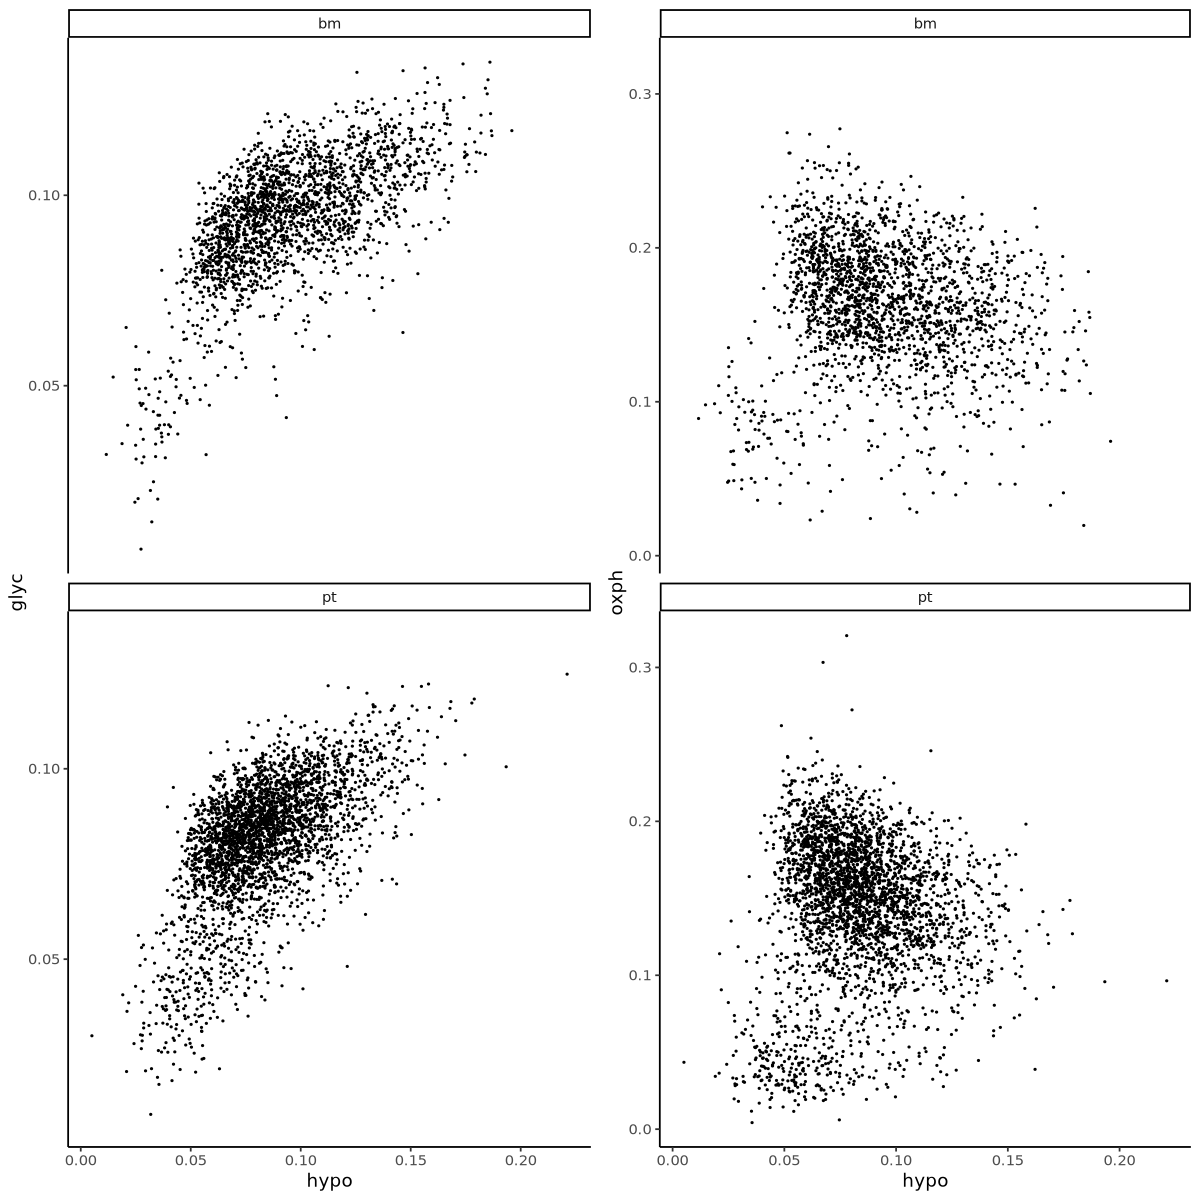

In [15]:
## Plot relationship between Hypoxia and Oxphos/Glycolysis scores in each condition.
fig_size(10, 10)
glyc.hypo.p <- ggplot(scm.feature.df, aes(x=hypo, y=glyc)) + 
    geom_point(size=0.25) + 
    facet_wrap(~ident, ncol=1) +
    # scale_color_viridis(option="plasma") + 
    theme_classic()
oxph.hypo.p <- ggplot(scm.feature.df, aes(x=hypo, y=oxph)) +
    facet_wrap(~ident, ncol=1) +
    geom_point(size=0.25) + 
    # scale_color_viridis(option="plasma") + 
    theme_classic()
grid.arrange(glyc.hypo.p, oxph.hypo.p, ncol=2)
hypo.corr.path <- file.path(fig.dir, "hypoxia_corr.pdf")
hypo.corr.g <- arrangeGrob(glyc.hypo.p, oxph.hypo.p, ncol=2)
ggsave(hypo.corr.path, hypo.corr.g, width=10, height=10)

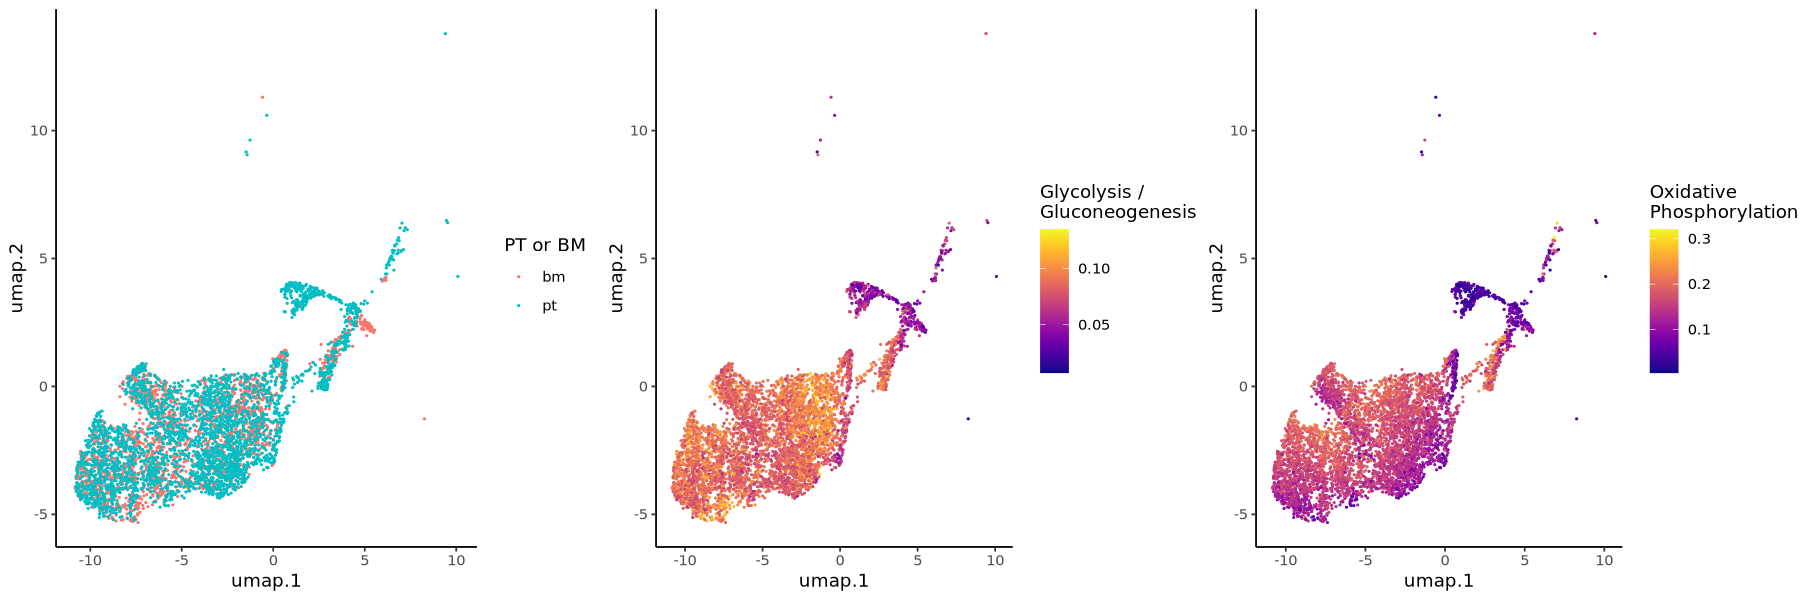

In [16]:
## Plot Glycolysis and OxPhos scores vs tumor cell UMAP.
fig_size(5, 15)
pt.bm.p <- ggplot(scm.feature.df, aes(x=umap.1, y=umap.2, color=pt.bm.ident)) + 
    geom_point(size=0.25) + 
    theme_classic() + 
    labs(color="PT or BM")
gluc.p <- ggplot(scm.feature.df, aes(x=umap.1, y=umap.2, color=glyc)) + 
    geom_point(size=0.25) + 
    scale_color_viridis(option="plasma") + 
    theme_classic() + 
    labs(color="Glycolysis /\nGluconeogenesis")
oxph.p <- ggplot(scm.feature.df, aes(x=umap.1, y=umap.2, color=oxph)) + 
    geom_point(size=0.25) + 
    scale_color_viridis(option="plasma") + 
    theme_classic() + 
    labs(color="Oxidative\nPhosphorylation")
grid.arrange(pt.bm.p, gluc.p, oxph.p, ncol=3)

In [17]:
# Reformat scMetabolism data for violin plotting
scm.feature.df.long <- melt(scm.feature.df, id.vars=c("umap1", "umap2", "ident"))

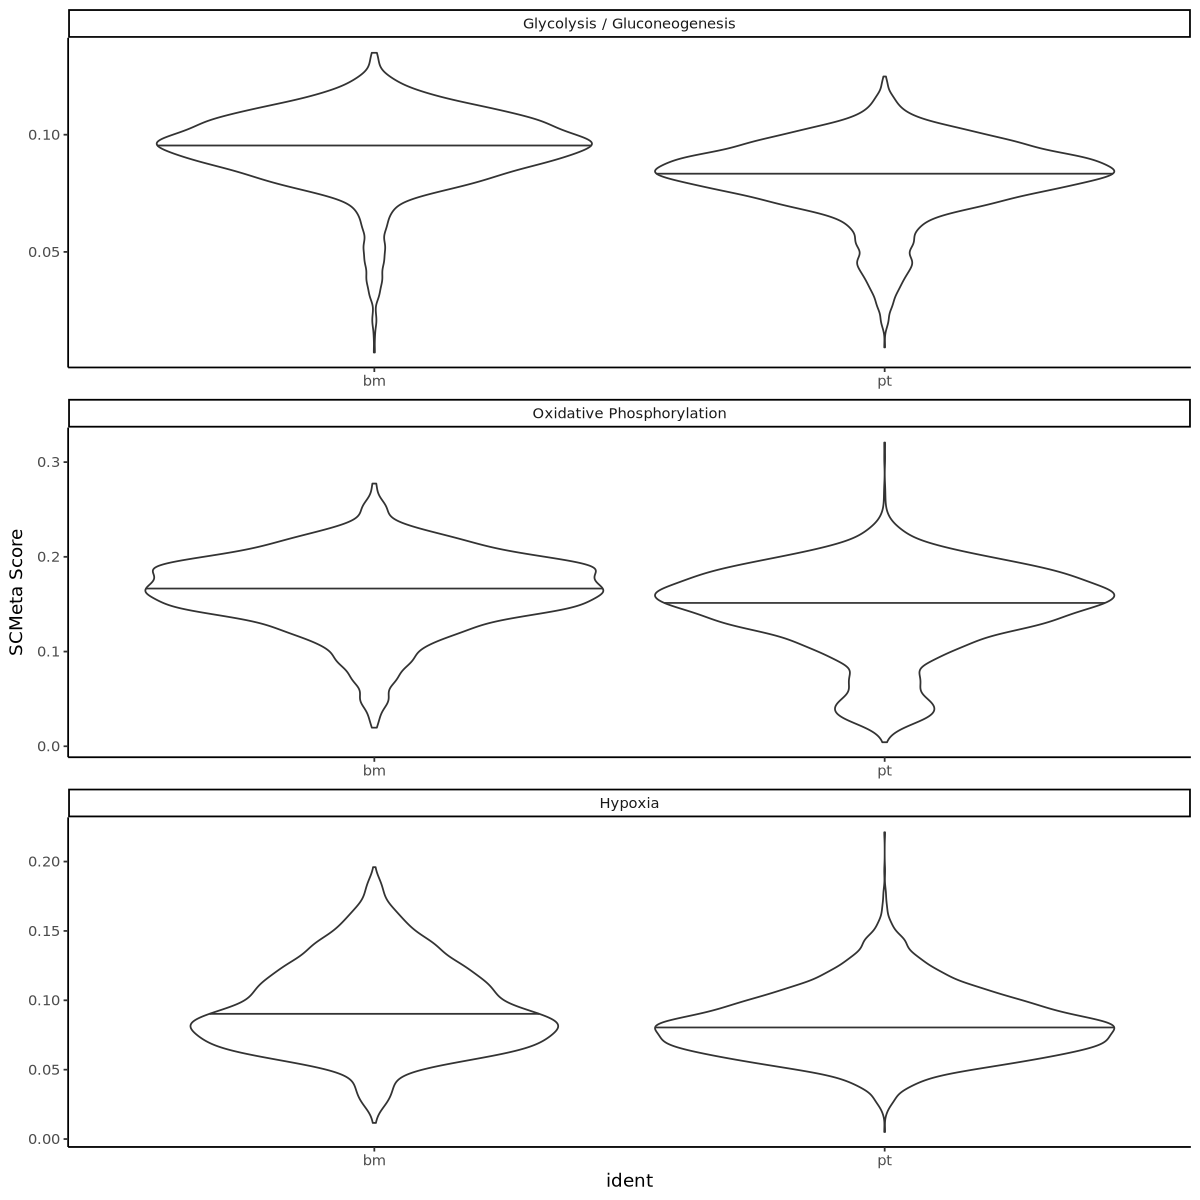

In [18]:
## Violin plots of scMetabolism scores at single-cell level for each condition and pathway.
fig_size(10, 10)
pathway.names <- c(
  'glyc'="Glycolysis / Gluconeogenesis",
  'oxph'="Oxidative Phosphorylation",
  'hypo'="Hypoxia"
)
path.vio.p <- ggplot(scm.feature.df.long, aes(x=ident, y=value)) + 
    facet_wrap(~variable, ncol=1, labeller=as_labeller(pathway.names), scales="free") + 
    geom_violin(draw_quantiles=c("0.5")) + 
    # geom_jitter(size=0.1, alpha=0.1) + 
    ylab("SCMeta Score") + 
    theme_classic()
path.vio.p
path.vio.path <- file.path(fig.dir, "mousehm_pathway_violin.pdf")
ggsave(plot=path.vio.p, filename=path.vio.path, width=10, height=10)